In [1]:
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
from random import seed, shuffle
from sklearn.linear_model import LogisticRegression
import pandas as pd
import sys
sys.path.insert(1, '/home/ptr@itd.local/code/fairness_triangle/tools')  # Update this path as needed
from gen_synth_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.use(["science", "grid"])
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.7
})


In [ ]:
rnd_seed = 0             # Fixed randomness for reproducability
flip_prob = 0.10          # Binary Label Noise probability
disc_factor =  np.pi/3   # Similarity of Y_sen to X  np.pi/4 
n_samples = 2000         # Number of samples per distribution (We have 2x in total)
split_ratio = 0.7        # Split into train and test set
c = 0.5                  # Cost of performance and fairness (Eq. 15 )
c_bar = 0.5  
lmd_example = 1                # Trade off between perf and fairn regressions (only used in vizualization)
lmd_start= -1
lmd_end= 4
lmd_interval = np.linspace(lmd_start, lmd_end, 40)
symmetric_fairness = False

In [8]:
X, Y, Y_sen, pX = generate_synthetic_data(False, n_samples, disc_factor, rnd_seed, True)
Y_corrupted = add_sym_noise(Y, flip_prob, rnd_seed)
Y_sen_corrupted = add_sym_noise(Y_sen, 0.0, rnd_seed) #We don't need to extra corrupt the sensitive attribute, because we already corrupted the input.
print(np.mean(Y == 1), np.mean(Y_sen == 1))
# Split data
split_index = int(split_ratio * len(X))
pX_train, pX_test =                 pX[:split_index],           pX[split_index:]
X_train, X_test =                   X[:split_index],            X[split_index:]
Y_train, Y_test =                   Y[:split_index],            Y[split_index:]
Y_corr_train, Y_corr_test =         Y_corrupted[:split_index],  Y_corrupted[split_index:]
Y_sen_train, Y_sen_test =           Y_sen[:split_index],        Y_sen[split_index:]
Y_sen_corr_train, Y_sen_corr_test = Y_sen_corrupted[:split_index], Y_sen_corrupted[split_index:]

print(np.unique(X_train), np.unique(Y_train), np.unique(Y_sen_train))
# Initialize and train models
p_reg = LogisticRegression().fit(X_train, Y_train)
p_reg_cor = LogisticRegression().fit(X_train, Y_corr_train)
f_reg = LogisticRegression().fit(X_train, Y_sen_train)
f_reg_cor = LogisticRegression().fit(X_train, Y_sen_corr_train)

0.5 0.475
[-12.26589138 -12.08981272 -11.49647026 ...   8.43932496   9.12792441
   9.85488984] [0. 1.] [0. 1.]


In [9]:
                 # tuning parameter for \bar{eta}(x) = 1{x > t}
c = 0.5                # cost for false negatives (Y=1 but predict 0)
c_bar = 0.5             # cost for false positives (Y=0 but predict 1)



# Base label distribution eta(x) = 1{x > 0}
eta = p_reg.predict_proba(X_test)[:,1]
sen_eta = f_reg.predict_proba(X_test)[:,1]

def B_lambda(eta_val, eta_bar_val, lmd, c=0.5, c_bar=0.5):
    """Implements B_λ(η, η̄_DP) = |η - c| * [[ (η - c) * (η - c - λ (η̄_DP - c̄)) < 0 ]]."""
    left = eta_val - c
    right = eta_val - c - lmd * (eta_bar_val - c_bar)
    indicator = (left * right) < 0
    return np.abs(left) * indicator

def pareto_frontier(eta, sen_eta, lmd, c=0.5, c_bar=0.5):
    """F(τ) = E_X[B_λ(η(X), η̄_DP(X))]"""
    B_vals = B_lambda(eta, sen_eta, lmd, c=c, c_bar=c_bar)
    return np.sum(pX_test * B_vals)

In [10]:
lambdas = np.linspace(lmd_start, lmd_end, lmd_interval.size) 
risks = [pareto_frontier(eta, sen_eta, lmd) for lmd in lambdas]

/tmp/ipykernel_57580/4012564092.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


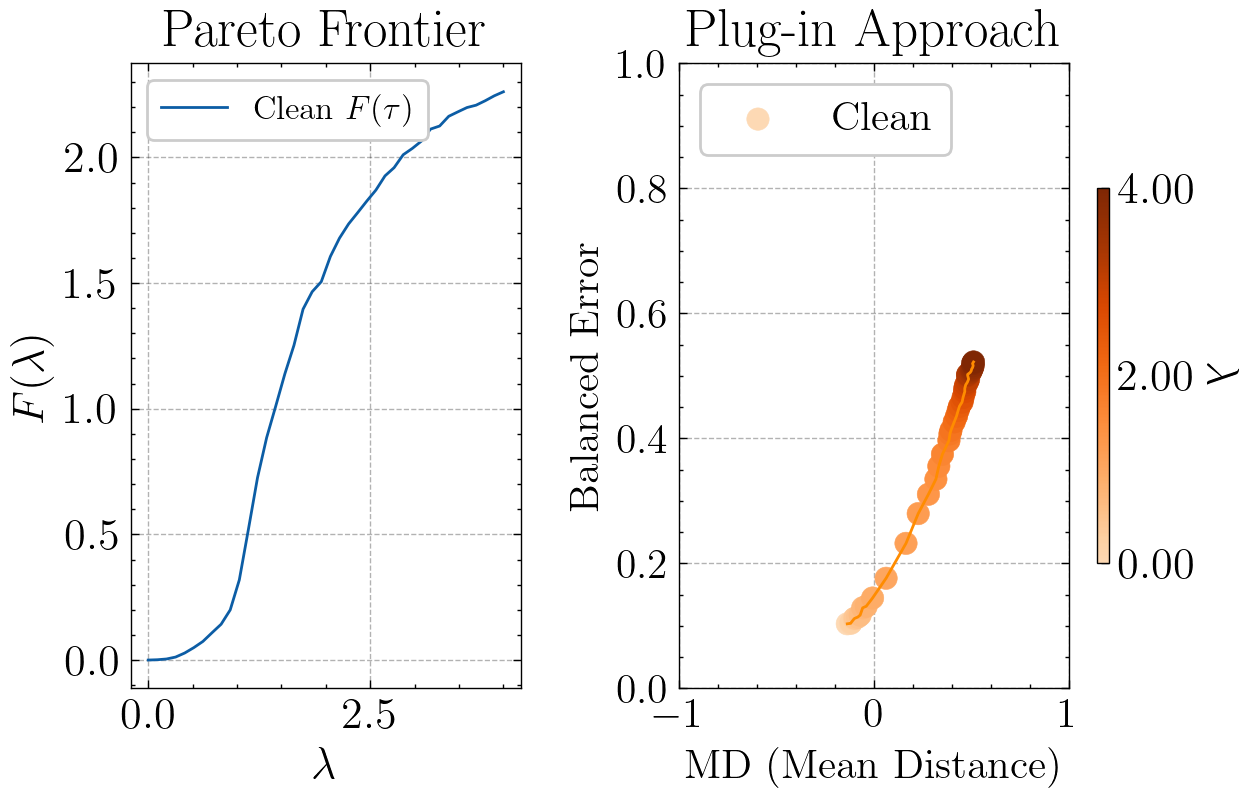

In [ ]:
textwidth =  7.285
aspect_ratio = 6/8
scale = 0.8
width = textwidth * scale
height = width * aspect_ratio

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, height)) 
# Sweep over lambda values and calculate metrics
BER_list = []
MD_list = []
DI_list = []
BER_list_corr = []
MD_list_corr = []
DI_list_corr = []

# lmd = how important is fairness
for lmd in lmd_interval:
    # Calculate 's' for each lambda
    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)
    BER = calc_BER(Y_pred, Y_test)
    MD = calc_MD(Y_pred, Y_sen_test, symmetric_fairness)
    DI = calc_DI(Y_pred, Y_sen_test, symmetric_fairness)
    BER_list.append(BER)
    MD_list.append(MD)
    DI_list.append(DI)


# Compute now with Corrupted labels
for lmd in lmd_interval:
    # Calculate 's' for each lambda
    s_2 = p_reg_cor.predict_proba(X_test)[:, 1] - c - lmd * (f_reg_cor.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred_2 = np.where(s_2 > 0, 1, 0)

    BER_2 = calc_BER(Y_pred_2, Y_test)
    MD_2 = calc_MD(Y_pred_2, Y_sen_test, symmetric_fairness)
    DI_2 = calc_DI(Y_pred_2, Y_sen_test, symmetric_fairness)
    
    BER_list_corr.append(BER_2)
    MD_list_corr.append(MD_2)
    DI_list_corr.append(DI_2)
    
results = pd.DataFrame({
    'lambda': lmd_interval,
    'BER_clean': BER_list,
    'MD_clean': MD_list,
    'DI_clean': DI_list,
    'BER_corr': BER_list_corr,
    'MD_corr': MD_list_corr,
    'DI_corr': DI_list_corr
})

      # Instead of fig = science_fig()

ax2.set_title("Plug-in Approach")
df = results
df = results.sort_values(by="lambda")


# Single colormap (orange in this case)
orange_cmap = truncate_colormap('Oranges', 0.2, 1.0)

# Plot line for clean results
ax2.plot(df["MD_clean"], df["BER_clean"],
        color="darkorange", linestyle='-', linewidth=1, label="_nolegend_")

# Scatter for clean results
sc = ax2.scatter(df["MD_clean"], df["BER_clean"], 
                c=df["lambda"], cmap=orange_cmap,
                label="Clean", linewidths=0.2, s=65)

# Add colorbar
cax = inset_axes(ax2,
                width="3%",
                height="60%",
                loc='center right',
                bbox_to_anchor=(0.1, 0, 1, 1),
                bbox_transform=ax2.transAxes,
                borderpad=0)

cbar = ax2.figure.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_label(r"$\lambda$", rotation=270, labelpad=15)

lambda_min, lambda_max = df["lambda"].min(), df["lambda"].max()

# Choose how many ticks you want (e.g. 5 evenly spaced)
all_ticks = np.linspace(lambda_min, lambda_max, 3)
all_ticklabels = [f"{v:.2f}" for v in all_ticks]

cbar.set_ticks(all_ticks)
cbar.set_ticklabels(all_ticklabels)

# Labels and formatting
ax2.set_xlabel("MD (Mean Distance)", fontsize=15)
ax2.set_ylabel("Balanced Error", fontsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax2.set_xlim(-1, 1)
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)
ax2.legend(loc=2, fontsize=15)


ax1.plot(lambdas, risks, linewidth=1, 
         label=r"Clean $F(\tau)$")
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel(r"$F(\lambda)$")
ax1.set_title("Pareto Frontier")
ax1.grid(True, alpha=0.3)
ax1.legend(loc=2, fontsize=12)

plt.tight_layout()
plt.savefig("../img/Used_In_MT/TheoVsPlugin", dpi=600)
plt.show()
